In [1]:
suppressPackageStartupMessages(suppressWarnings(library(lintr))) # linting
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # color palettes
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(png))

In [2]:
# helper functions
load_image <- function(path){
    img <- png::readPNG(path)
    # Convert the image to a raster object
    g <- grid::rasterGrob(img, interpolate=TRUE)

    # Create a ggplot
    p <- ggplot() +
    annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
    theme_void()
    return(p)
}

In [3]:
# getting all paths

# confusing matrix paths
confusion_matrix_path <- file.path("../../results/2.modeling/confusion_matrix.csv.gz")
overlapping_confusion_matrix_path <- file.path("../../results/2.modeling/jump_overlap_confusion_matrix.csv.gz")

# f1 score path
f1_score_path <- file.path("../../results/2.modeling/all_f1_scores.csv.gz")

# precision and recall curve path
pr_file_path <- file.path("../../results/2.modeling/precision_recall_scores.csv.gz")

# probability plot
cyto_proba_path <- file.path("../../results/3.jump_analysis/cytoskeletal_proba_scores.csv.gz")

# path to workflow image
wf_image <- file.path("./figures/workflow_fig.png")

# create figures and supplemental dir
dir.create("figures/supplemental", recursive = TRUE)

Warning message in dir.create("figures/supplemental", recursive = TRUE):
“'figures/supplemental' already exists”


In [4]:
# loading all data

# loading confusion matrices
cm_df <- read.csv(confusion_matrix_path, sep = ",")
overlapping_cm_df <- read.csv(overlapping_confusion_matrix_path, sep = ",")

# loading f1 score paths
f1_df <- read.csv(f1_score_path, sep = ",")

# loading pr curve data
pr_df <- read.csv(pr_file_path)

# loading probabilities
cyto_proba_df <- read.csv(cyto_proba_path)

# loading workflow image
fig2_A_wf_image <- load_image(wf_image)

In [5]:
# pre-formatting data before plotting

# Update 'shuffled_model' column in cm_df
cm_df <- cm_df %>%
  mutate(shuffled_model = replace(shuffled_model, shuffled_model == "False", "Not Shuffled"),
         shuffled_model = replace(shuffled_model, shuffled_model == "True", "Shuffled"))

# Update 'shuffled_model' column in overlapping_cm_df
overlapping_cm_df <- overlapping_cm_df %>%
  mutate(shuffled_model = replace(shuffled_model, shuffled_model == "False", "Not Shuffled"),
         shuffled_model = replace(shuffled_model, shuffled_model == "True", "Shuffled"))

# Update 'shuffled' column in f1_df
f1_df <- f1_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not Shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"))
# update one of the shuffled_model columns to Shuffled and Not Shuffled
pr_df <- pr_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not Shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"))


# Update 'shuffled_model' column in proba_df
cyto_proba_df <- cyto_proba_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not Shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"))

# Adding the new column based on the condition
cyto_proba_df <- cyto_proba_df %>%
  mutate(injury = ifelse(grepl('Cytoskeletal', pred_injury), 'Cyto Injury', 'Other Injuries'))

## Update the 'injury' column based on 'datatype' condition
cyto_proba_df <- cyto_proba_df %>%
  mutate(injury = ifelse(datatype == "JUMP Overlap", "Cyto JUMP Overlap", injury))


# # replacing True and False to shuffled to non shuffled
# proba_df$shuffled_model <- ifelse(proba_df$shuffled_model == "False", "Not Shuffled",
#                                       ifelse(proba_df$shuffled_model == "True", "Shuffled", proba_df$shuffled_model))

## Figure 2 Panel A: Workflow Diagram

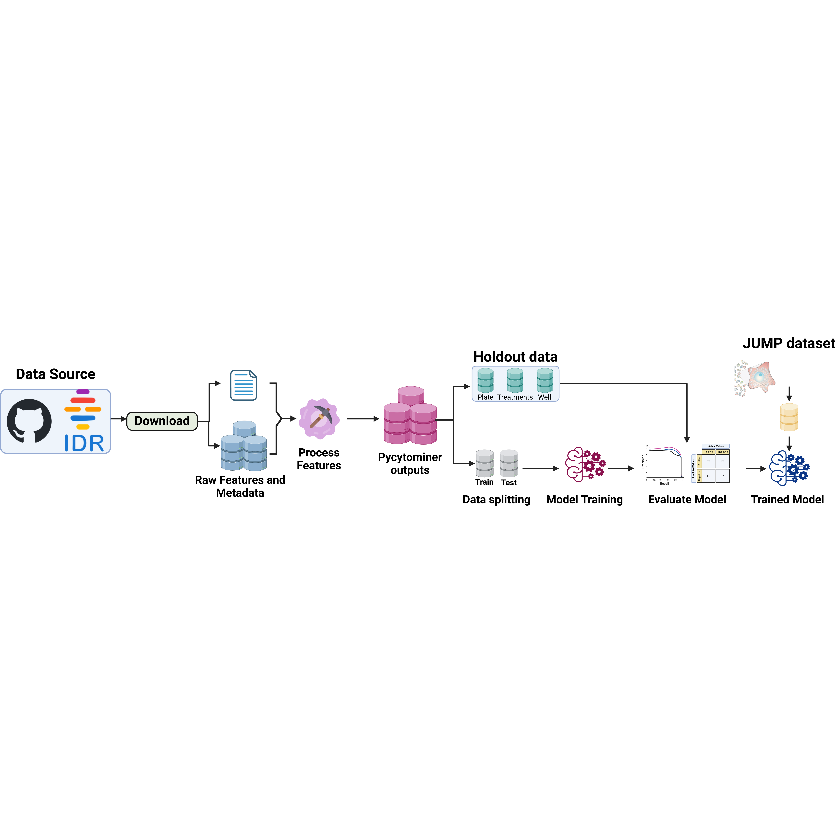

In [6]:
fig2_A_wf_image

## Figure 2 Panel B: PR Cruves for Train and Test split

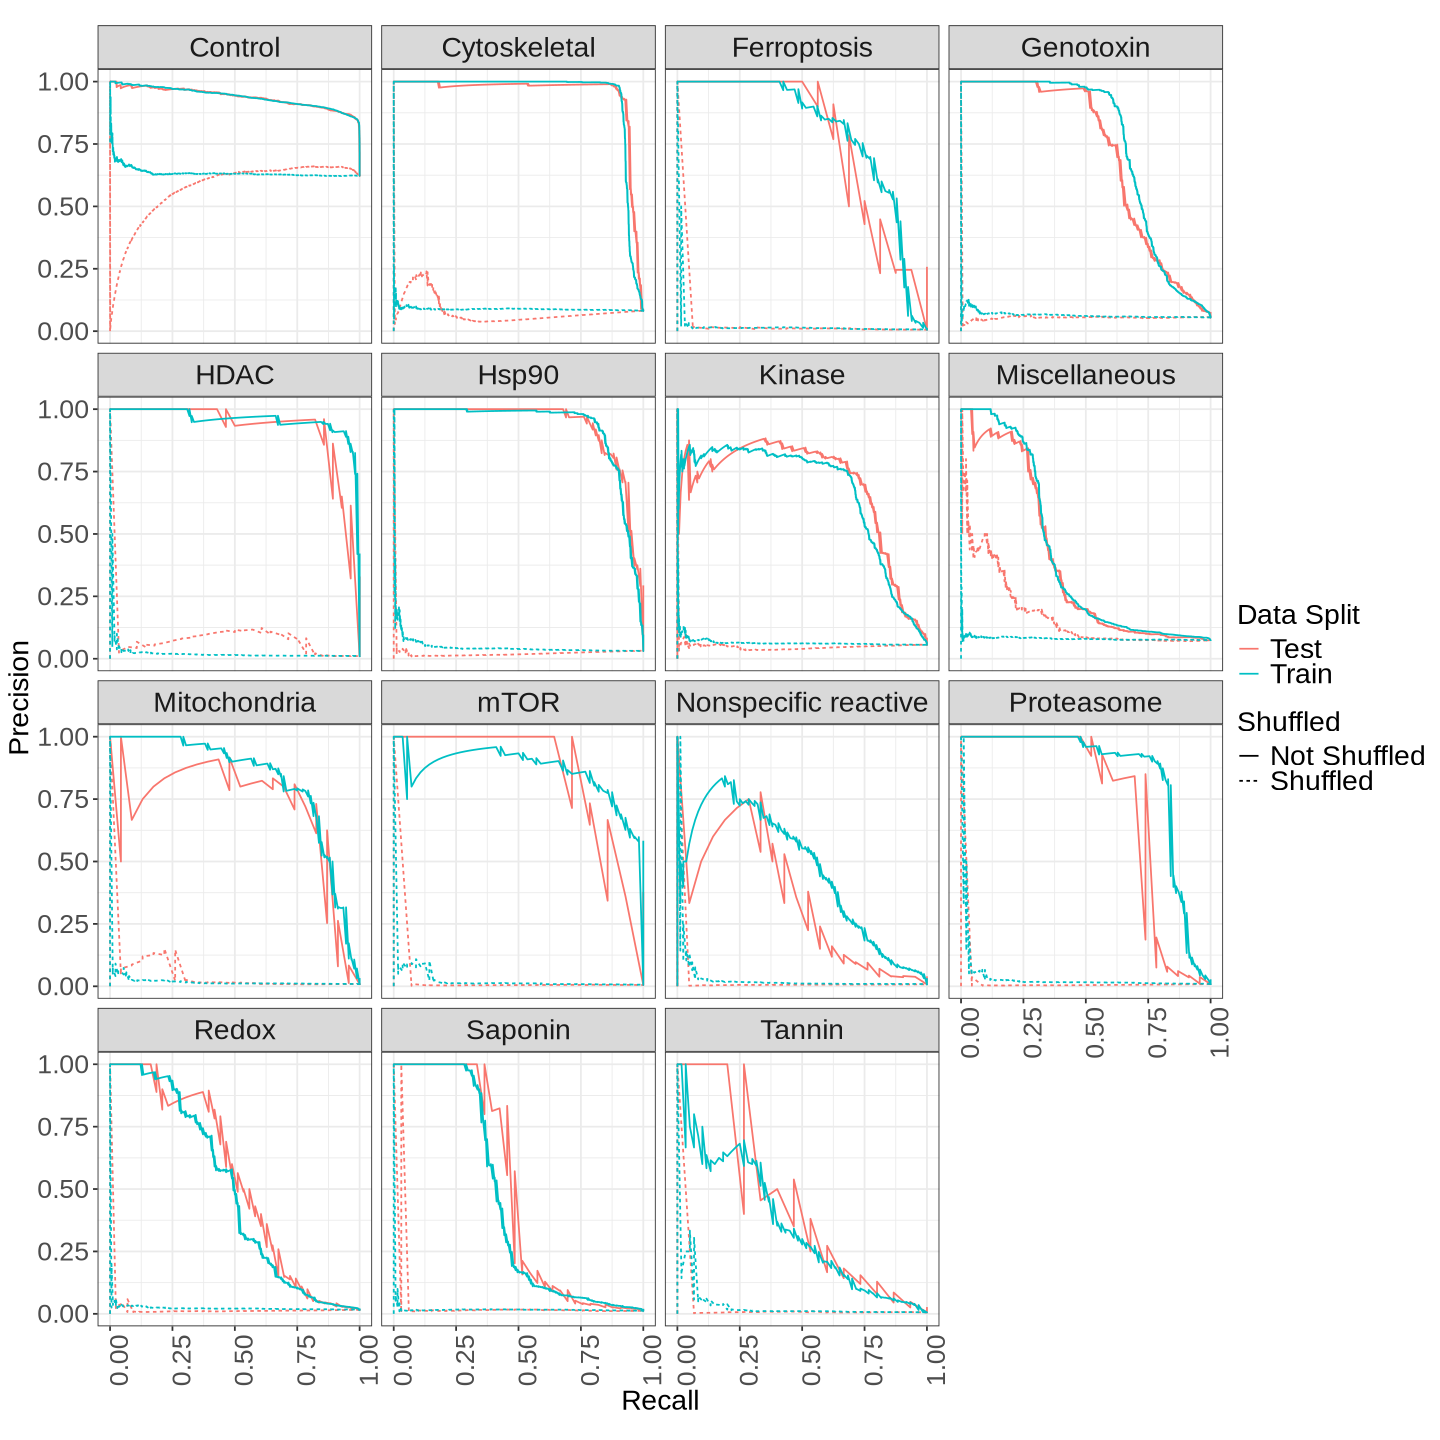

In [7]:
# Filter the dataframe to select only "test", "train", and "plate_holdout" datasets
filtered_pr_df <- pr_df %>%
  filter(dataset_type %in% c("Test", "Train"))

# Create line_id column
filtered_pr_df <- filtered_pr_df %>%
  mutate(line_id = case_when(
    dataset_type == "Test" & shuffled == "Not Shuffled" ~ "Test + Not Shuffled",
    dataset_type == "Test" & shuffled == "Shuffled" ~ "Test + Shuffled",
    dataset_type == "Train" & shuffled == "Not Shuffled" ~ "Train + Not Shuffled",
    dataset_type == "Train" & shuffled == "Shuffled" ~ "Train + Shuffled",
  )) %>%
  mutate(is_train_test = if_else(dataset_type %in% c("test", "train"), "test_train", "plate_holdout"))

# plot data
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

fig2_B_pr_curve_plot_train_test <- ggplot(filtered_pr_df, aes(x = recall, y = precision)) +
    geom_line(aes(color = dataset_type, linetype = shuffled)) +
    facet_wrap(~injury_type) +
    xlab("Recall") +
    ylab("Precision") +
    theme_bw() +
    theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.1, "cm"),
        legend.key.size = unit(0.7, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90, size = 16),
        axis.text.y = element_text(size = 16),
        strip.text = element_text(size = 17),
        strip.text.x = element_text(margin = margin(t=0.2, b=0.2, r=0, l=0, "cm")),
        axis.title = element_text(size = 17),
        legend.title = element_text(size = 17),
        legend.text = element_text(size = 17)) +
    labs(color = "Data Split", linetype = "Shuffled") +
    ggplot2::coord_fixed()

ggsave("figures/fig2_B_only_test_train_pr_curve.png", width = width, height = height, dpi=600)

fig2_B_pr_curve_plot_train_test

## Figure 2 Panel C: Creating F1 score plots  (only test split)

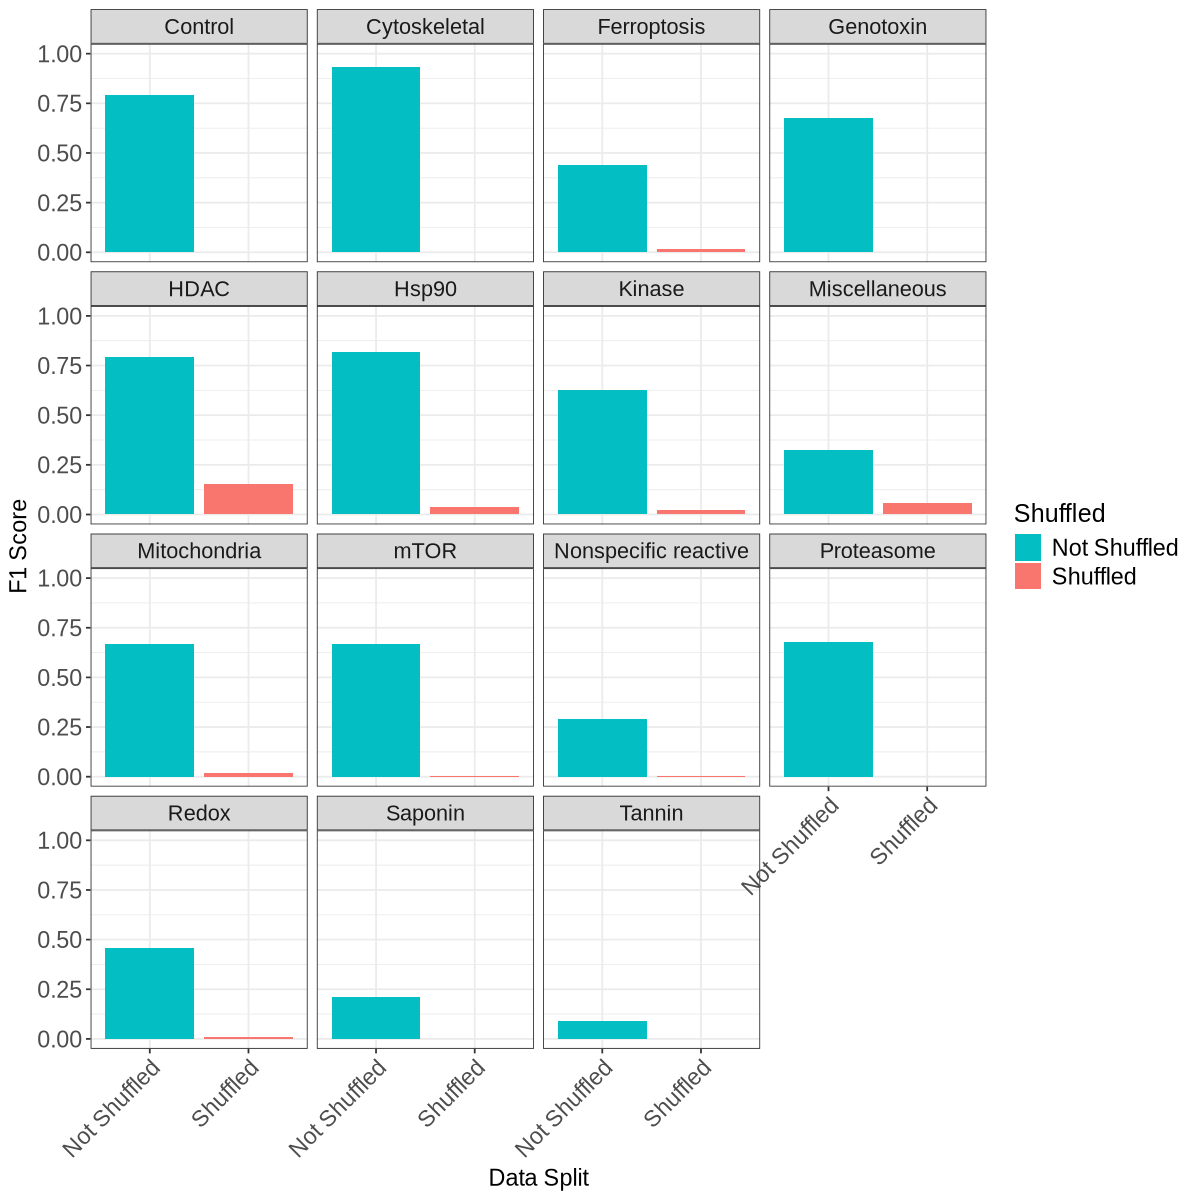

In [9]:
# image size
img_height <- 10
img_width <- 10

options(repr.plot.width = img_width, repr.plot.height = img_height)

test_f1_df <- f1_df %>%
  filter(dataset_type %in% "Test")

fig2_C_f1_bar_plot <- ggplot(test_f1_df, aes(x = shuffled , y = f1_score, fill = shuffled)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_bw() +
  ylim(0, 1) +
  facet_wrap(~injury_type) +
  labs(y = "F1 Score", x = "Data Split", fill = "Shuffled") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(hjust = 1, size = 14),
        legend.title = element_text(size = 15),
        legend.text = element_text(size = 14),
        strip.text = element_text(size = 13),
        axis.title.y = element_text(size = 14),
        axis.title.x = element_text(size = 14)
        ) +
  scale_fill_manual(values = c(
      "Shuffled" = "#f8766d",
      "Not Shuffled" = "#03bfc4"
    ))

ggsave(filename = "figures/fig2_C_f1_score_barplots.png", height = img_height, width = img_width, dpi = 600)
fig2_C_f1_bar_plot

## Figure 2 Panel D: Confusion Matrix with Train and Test split

In [11]:
# creating final model confusion matrix with Non-shuffled data
final_model_cm <- cm_df %>%
  filter(shuffled_model == "Not Shuffled" & dataset_type %in% c("Train", "Test", "Plate Holdout", "Well Holdout"))

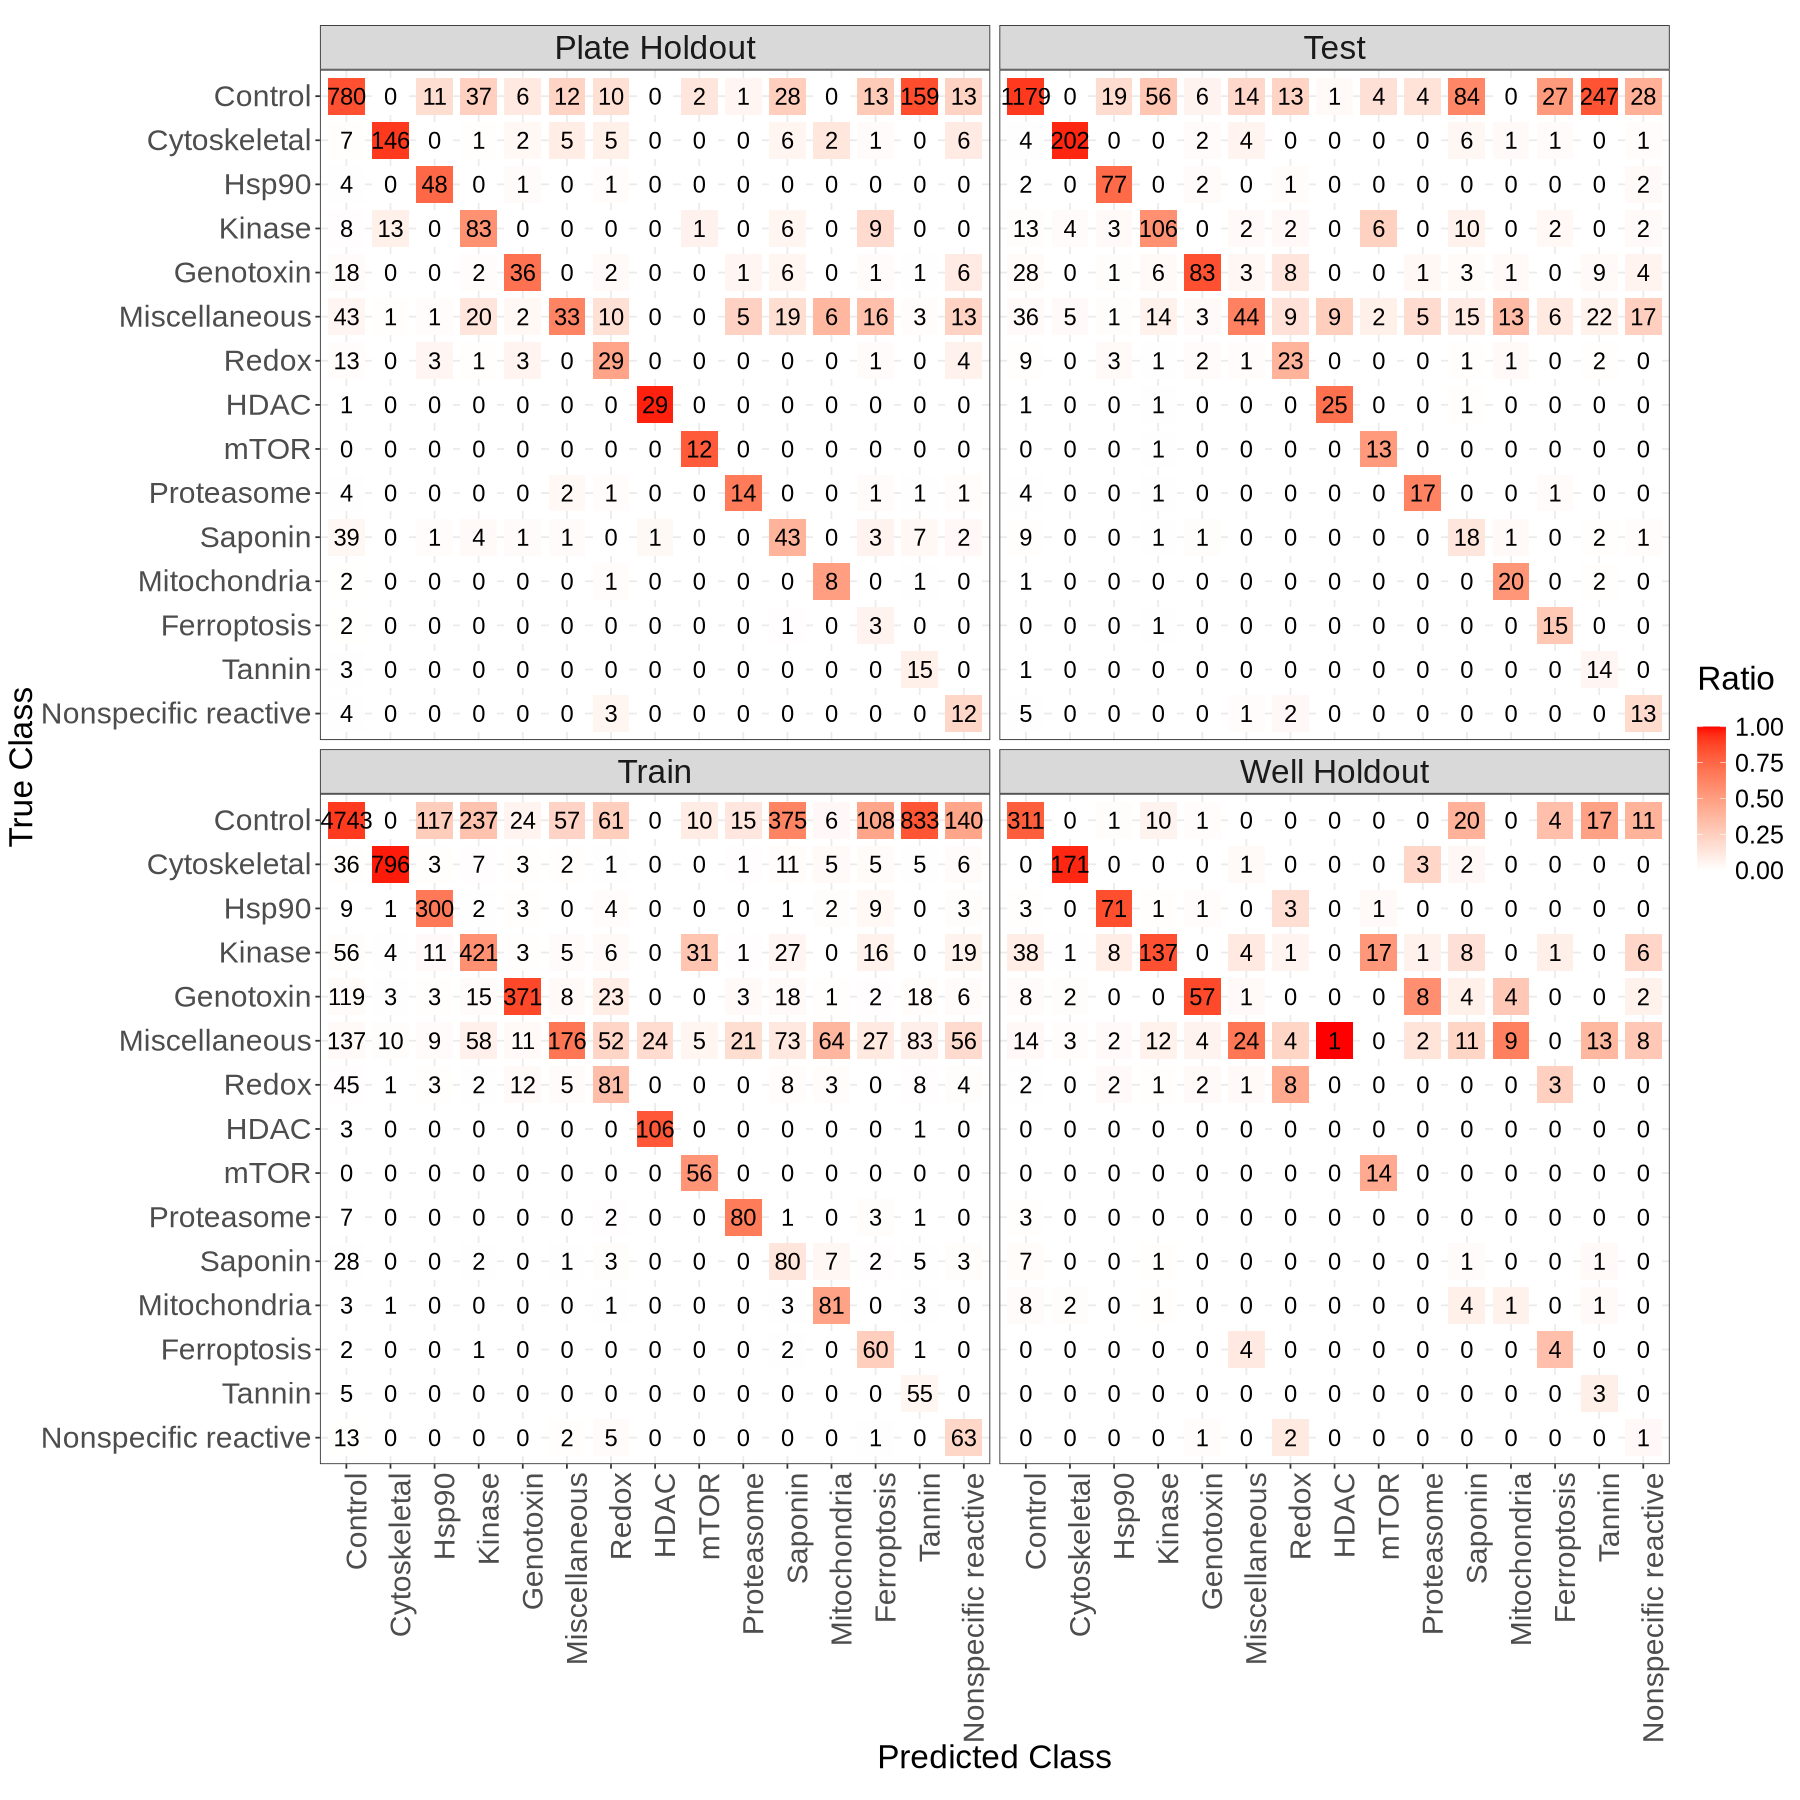

In [18]:
# image size
img_height <- 15
img_width <- 15

options(repr.plot.width = img_width, repr.plot.height = img_height)

# Define the desired order of x-axis labels
x_label_order <- c('Control', 'Cytoskeletal', 'Hsp90', 'Kinase', 'Genotoxin', 'Miscellaneous', 'Redox', 'HDAC', 'mTOR', 'Proteasome', 'Saponin', 'Mitochondria', 'Ferroptosis', 'Tannin', 'Nonspecific reactive')

# Reorder the predicted_labels factor variable with the desired order
final_model_cm$true_labels <- factor(final_model_cm$true_labels, levels = rev(unique(final_model_cm$true_labels)))
final_model_cm$predicted_labels <- factor(final_model_cm$predicted_labels, levels = x_label_order)

# Now proceed with plotting
fig2_D_final_model_cm <- (
    ggplot(final_model_cm, aes(x = predicted_labels, y = true_labels))
    + facet_wrap(~dataset_type)
    + geom_point(aes(color = recall), size = 10, shape = 15)
    + geom_text(aes(label = count), size = 5)
    + scale_color_gradient("Ratio", low = "white", high = "red", limits = c(0, 1))
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
    + theme(
        # legend settings
        legend.title =  element_text(size = 20, margin = margin(b = 20)),
        legend.text = element_text(size = 15),

        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 18),
        axis.text.y = element_text(hjust = 1, size = 18),
        axis.title.x.bottom = element_text(size = 20),
        axis.title.y.left = element_text(size = 20)
        )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/fig2_D_training_confusion_matrix.png", height = height, width = width, dpi = 600)

fig2_D_final_model_cm


## Supplemental Figure 3: Confusion matrix of Under Performing Treatment Holdout Predictions 

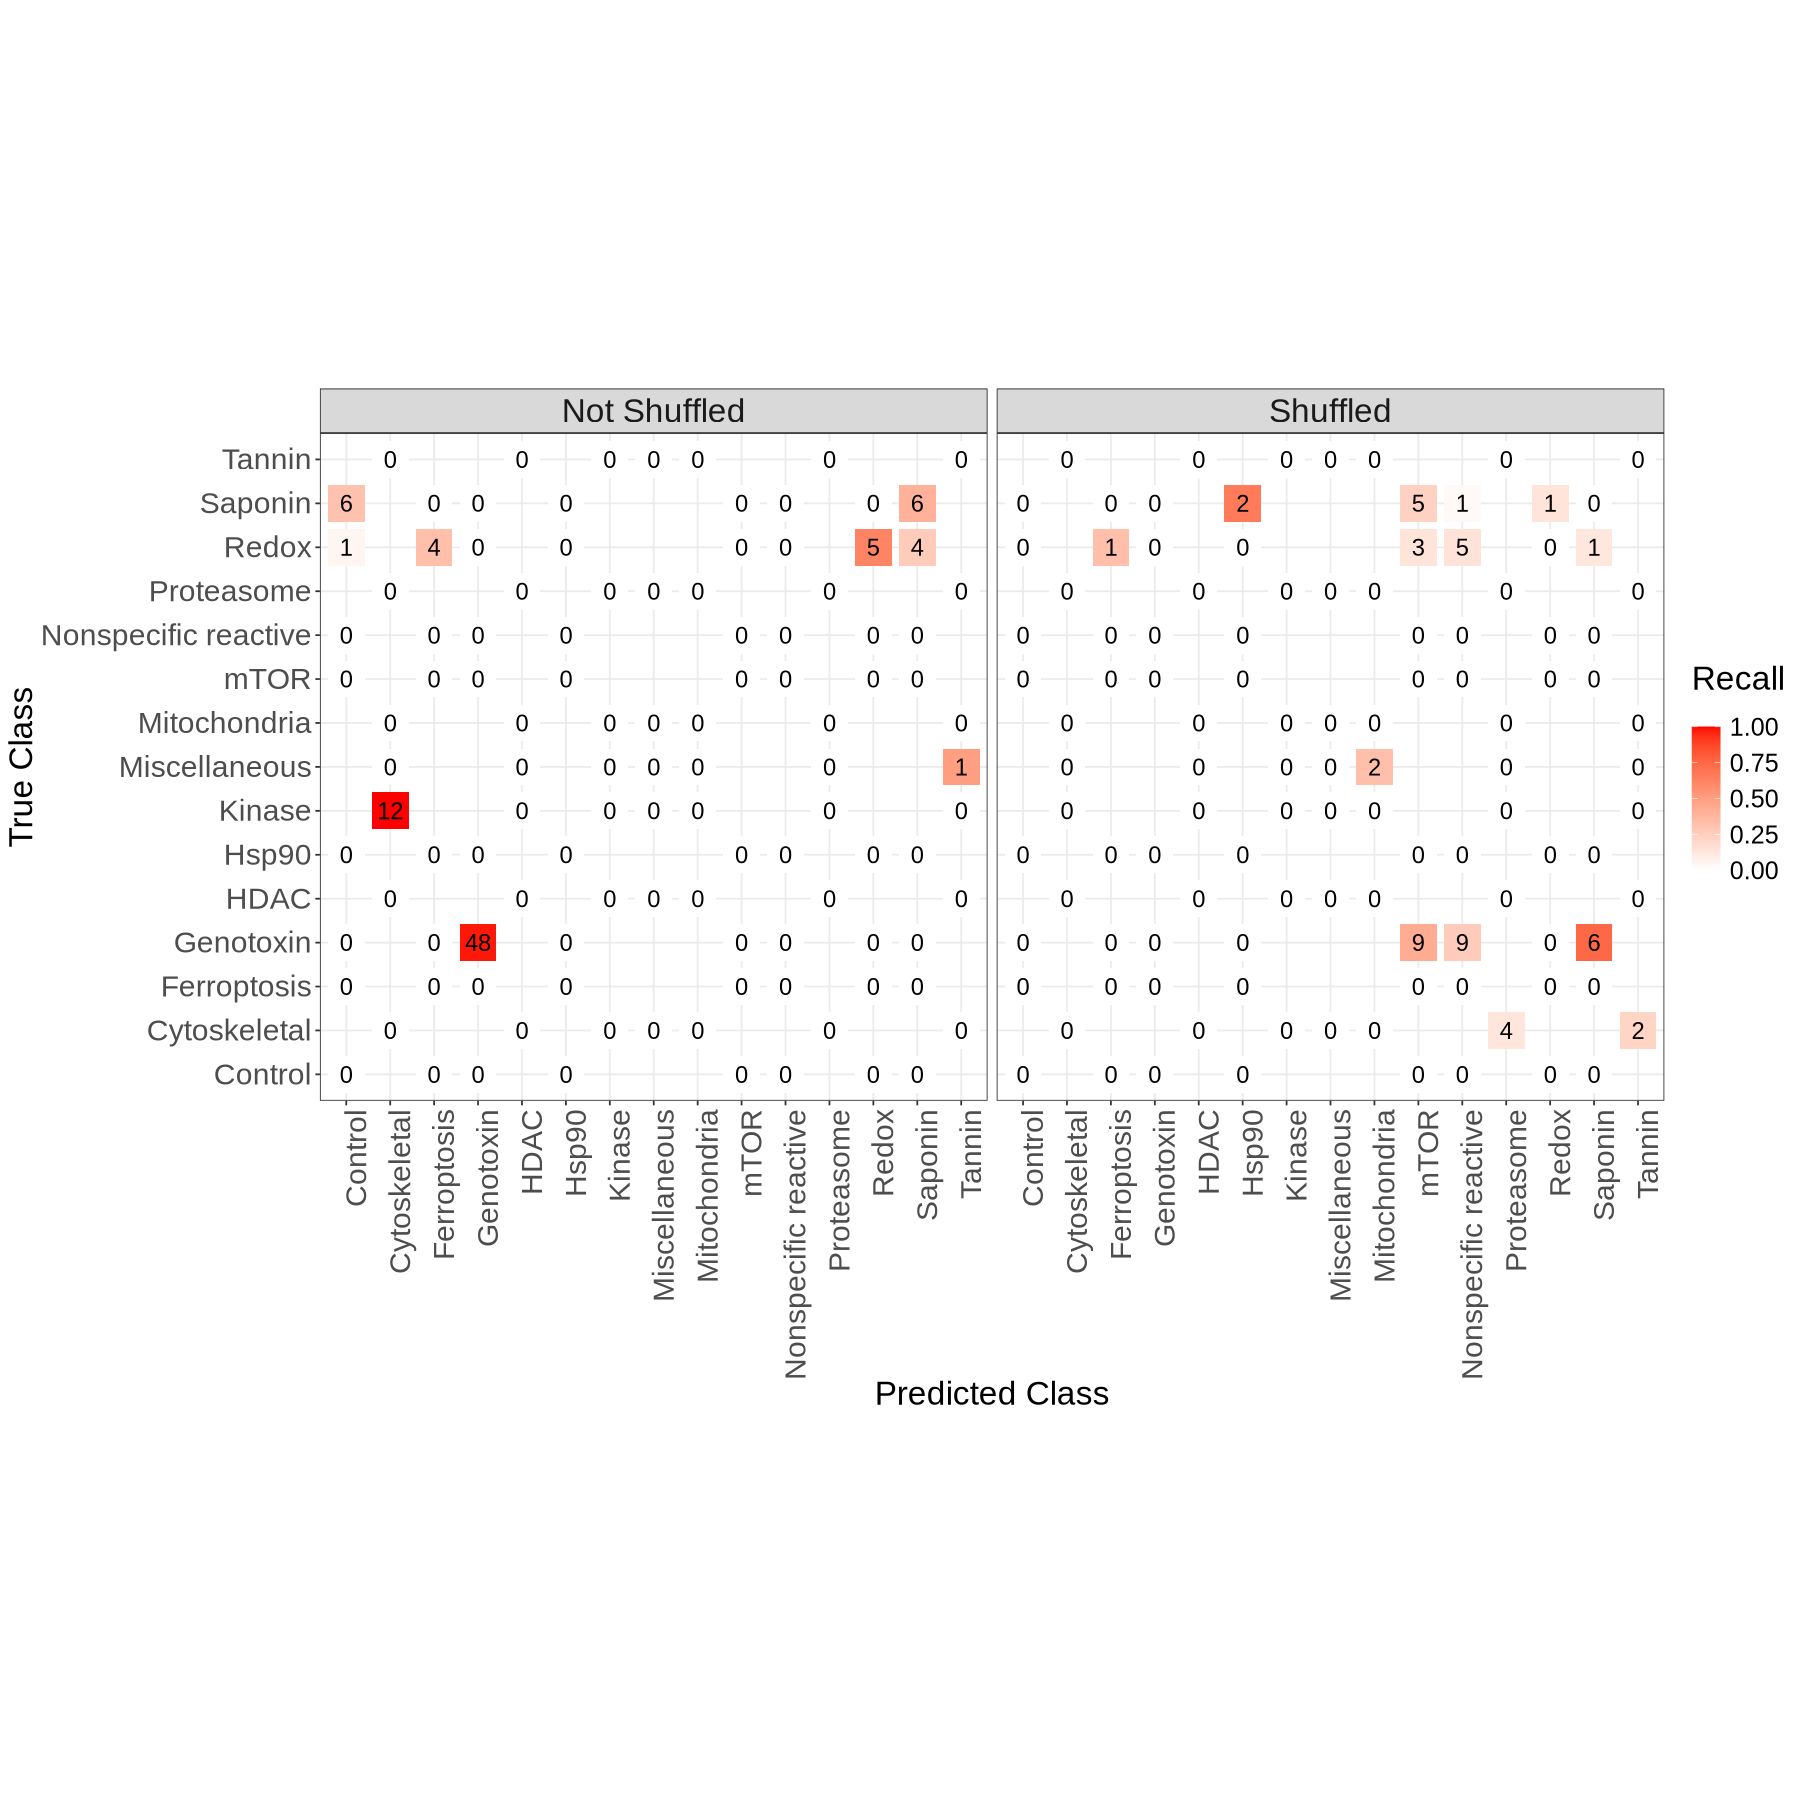

In [ ]:
# creating final model confusion matrix with Non-shuffled data
treat_cm <- cm_df %>%
  filter(shuffled_model == c("Not Shuffled", "Shuffled") & dataset_type %in% "Treatment Holdout")

# size of plot
width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)

sfig3_treatment_holdout_cm <- (
    ggplot(treat_cm, aes(x = predicted_labels, y = true_labels))
    + facet_wrap(~shuffled_model)
    + geom_point(aes(color = recall), size = 10, shape = 15)
    + geom_text(aes(label = count), size = 5)
    + scale_color_gradient("Recall", low = "white", high = "red", limits = c(0, 1))
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
    + theme(
        # legend settings
        legend.title =  element_text(size = 20, margin = margin(b = 20)),
        legend.text = element_text(size = 15),

        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 18),
        axis.text.y = element_text(hjust = 1, size = 18),
        axis.title.x.bottom = element_text(size = 20),
        axis.title.y.left = element_text(size = 20)
        )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/sfig3_treatment_holdout_confusion_matrix.png", height = height, width = width, dpi = 600)

sfig3_treatment_holdout_cm

## Supplemental Figure 2: Confusion matrix with Shuffled model 

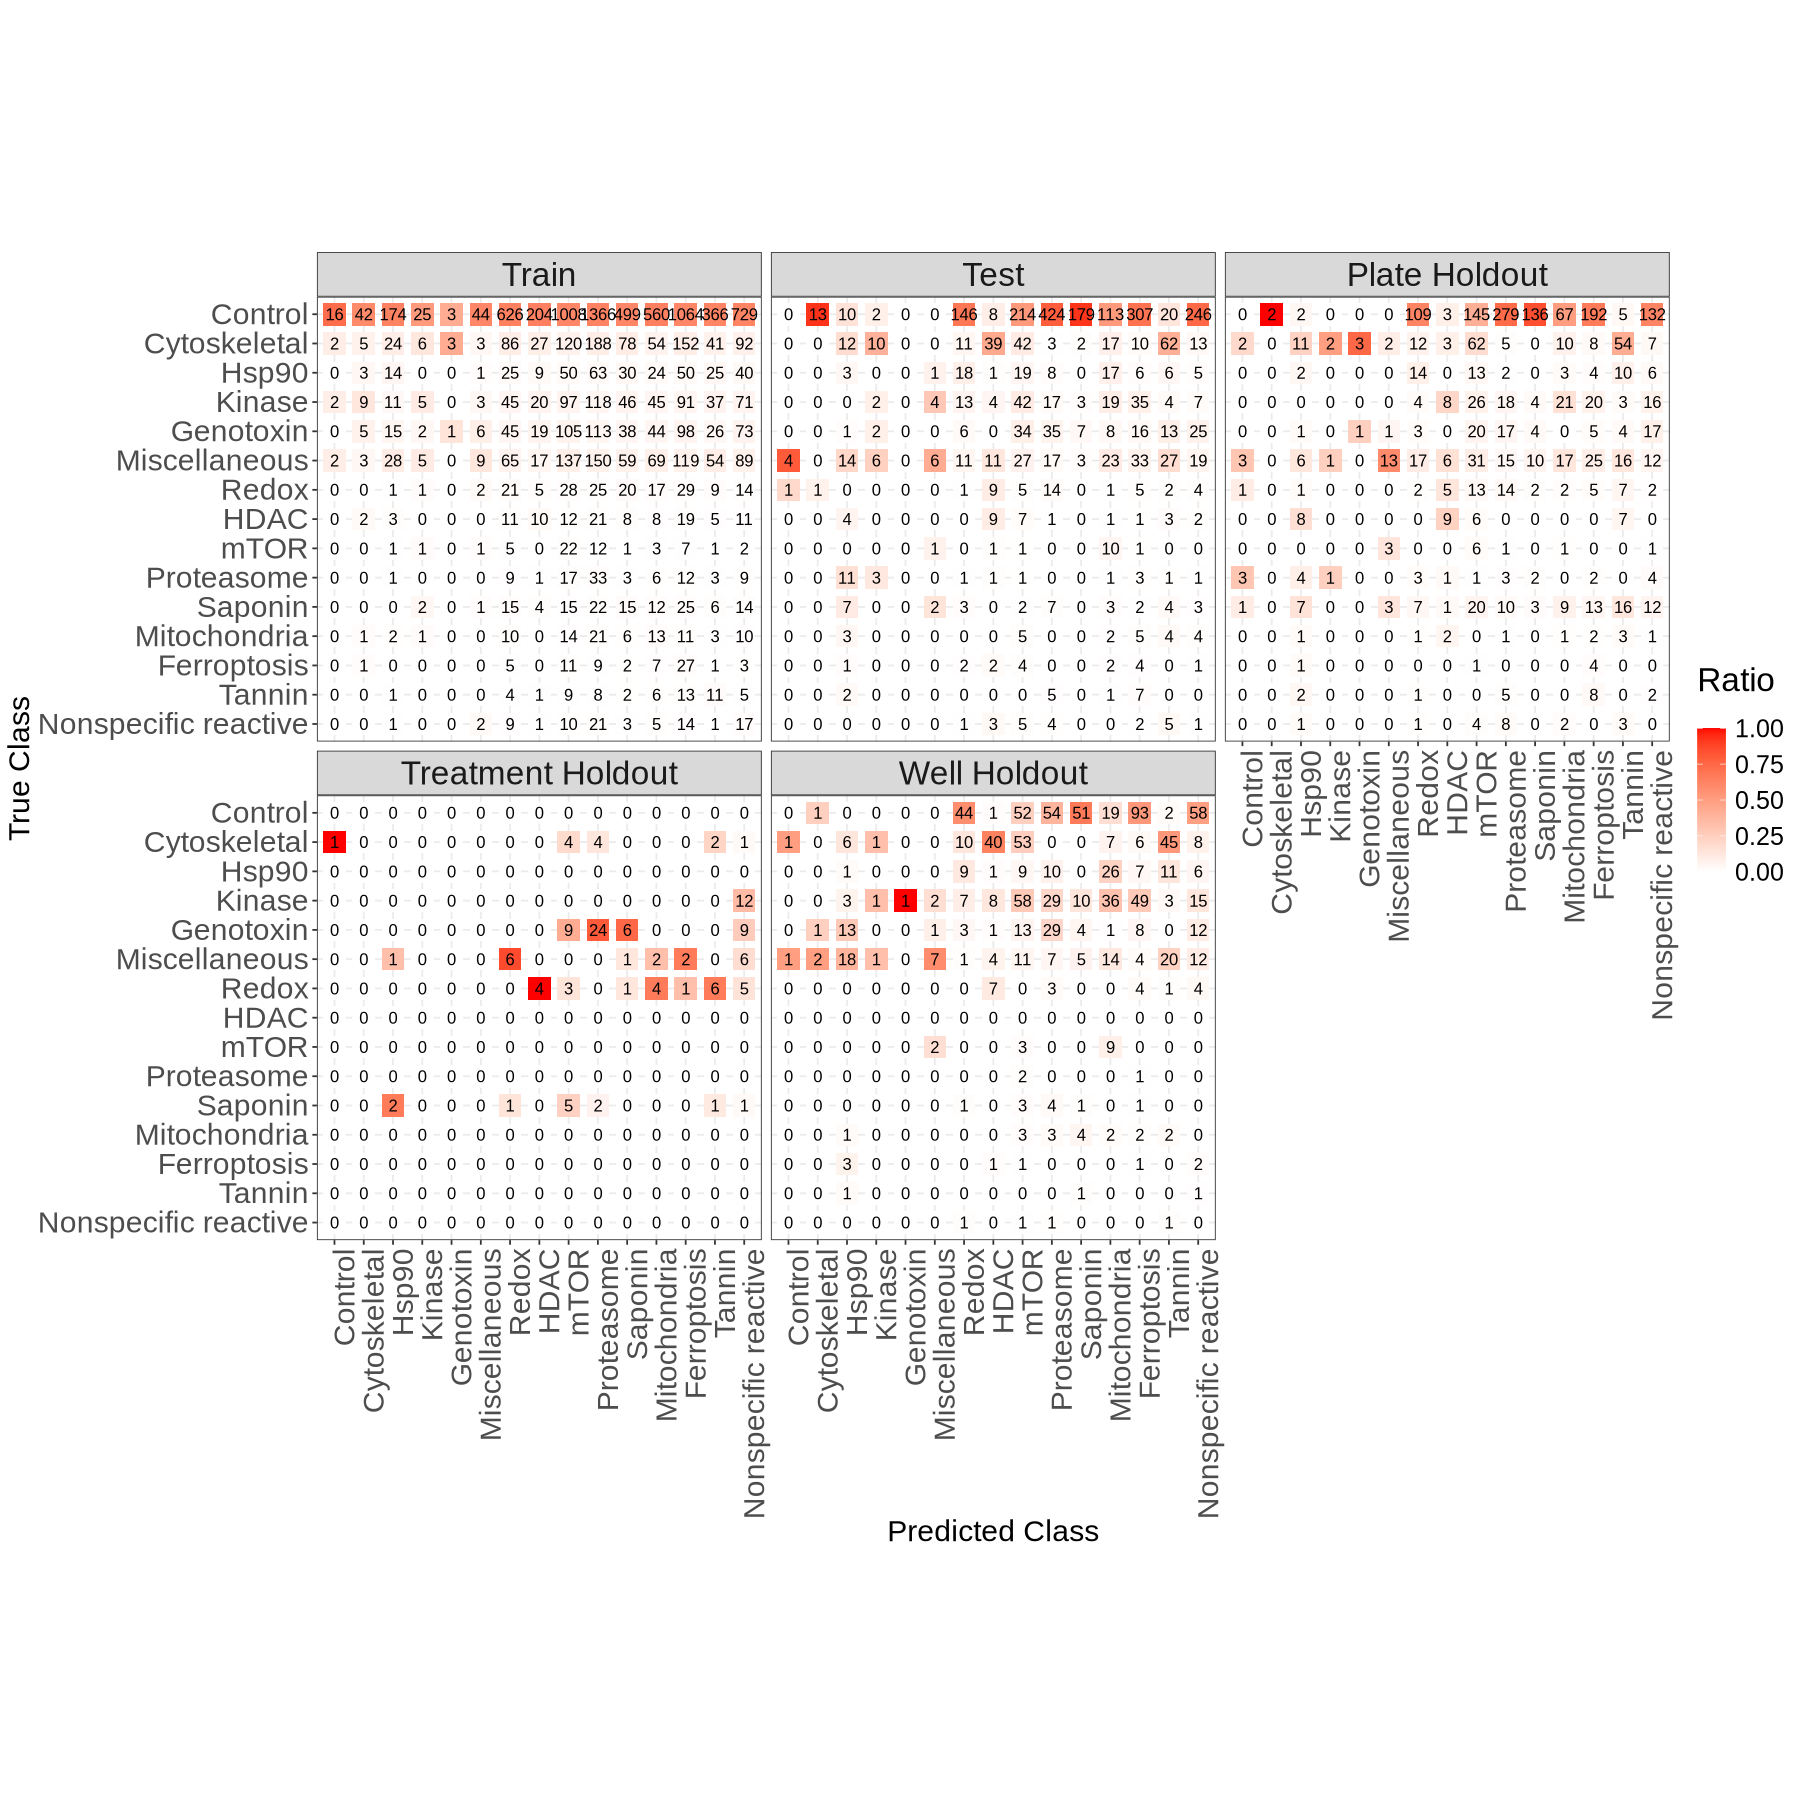

In [20]:
width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)

# creating final model confusion matrix with Non-shuffled data
final_model_cm <- cm_df %>%
  filter(shuffled_model == "Shuffled" & dataset_type %in% c("Train", "Test", "Plate Holdout", "Treatment Holdout", "Well Holdout"))

# Reorder the predicted_labels factor variable with the desired order
x_label_order <- c('Control', 'Cytoskeletal', 'Hsp90', 'Kinase', 'Genotoxin', 'Miscellaneous', 'Redox', 'HDAC', 'mTOR', 'Proteasome', 'Saponin', 'Mitochondria', 'Ferroptosis', 'Tannin', 'Nonspecific reactive')
final_model_cm$true_labels <- factor(final_model_cm$true_labels, levels = rev(unique(final_model_cm$true_labels)))
final_model_cm$predicted_labels <- factor(final_model_cm$predicted_labels, levels = x_label_order)

# Define the desired order of facet levels
facet_order <- c("Train", "Test", "Plate Holdout", "Treatment Holdout", "Well Holdout")
final_model_cm$dataset_type <- factor(final_model_cm$dataset_type, levels = facet_order)

sfig2_model_cm <- (
    ggplot(final_model_cm, aes(y = true_labels, x = predicted_labels))
    + facet_wrap(~dataset_type)
    + geom_point(aes(color = recall), size = 6, shape = 15)
    + geom_text(aes(label = count), size = 3.5)
    + scale_color_gradient("Ratio", low = "white", high = "red", limits = c(0, 1))
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
      + theme(
        # legend settings
        legend.title =  element_text(size = 20, margin = margin(b = 20)),
        legend.text = element_text(size = 15),
        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 18),
        axis.text.y = element_text(hjust = 1, size = 18),
        axis.title.x.bottom = element_text(size = 18),
        axis.title.y.left = element_text(size = 18)
        )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/supplemental/sfig2_shuffled_confusion_matrix.png", height = height, width = width, dpi = 600)

sfig2_model_cm

## Supplmental Figure Y: PR Curve of the plate holdouts

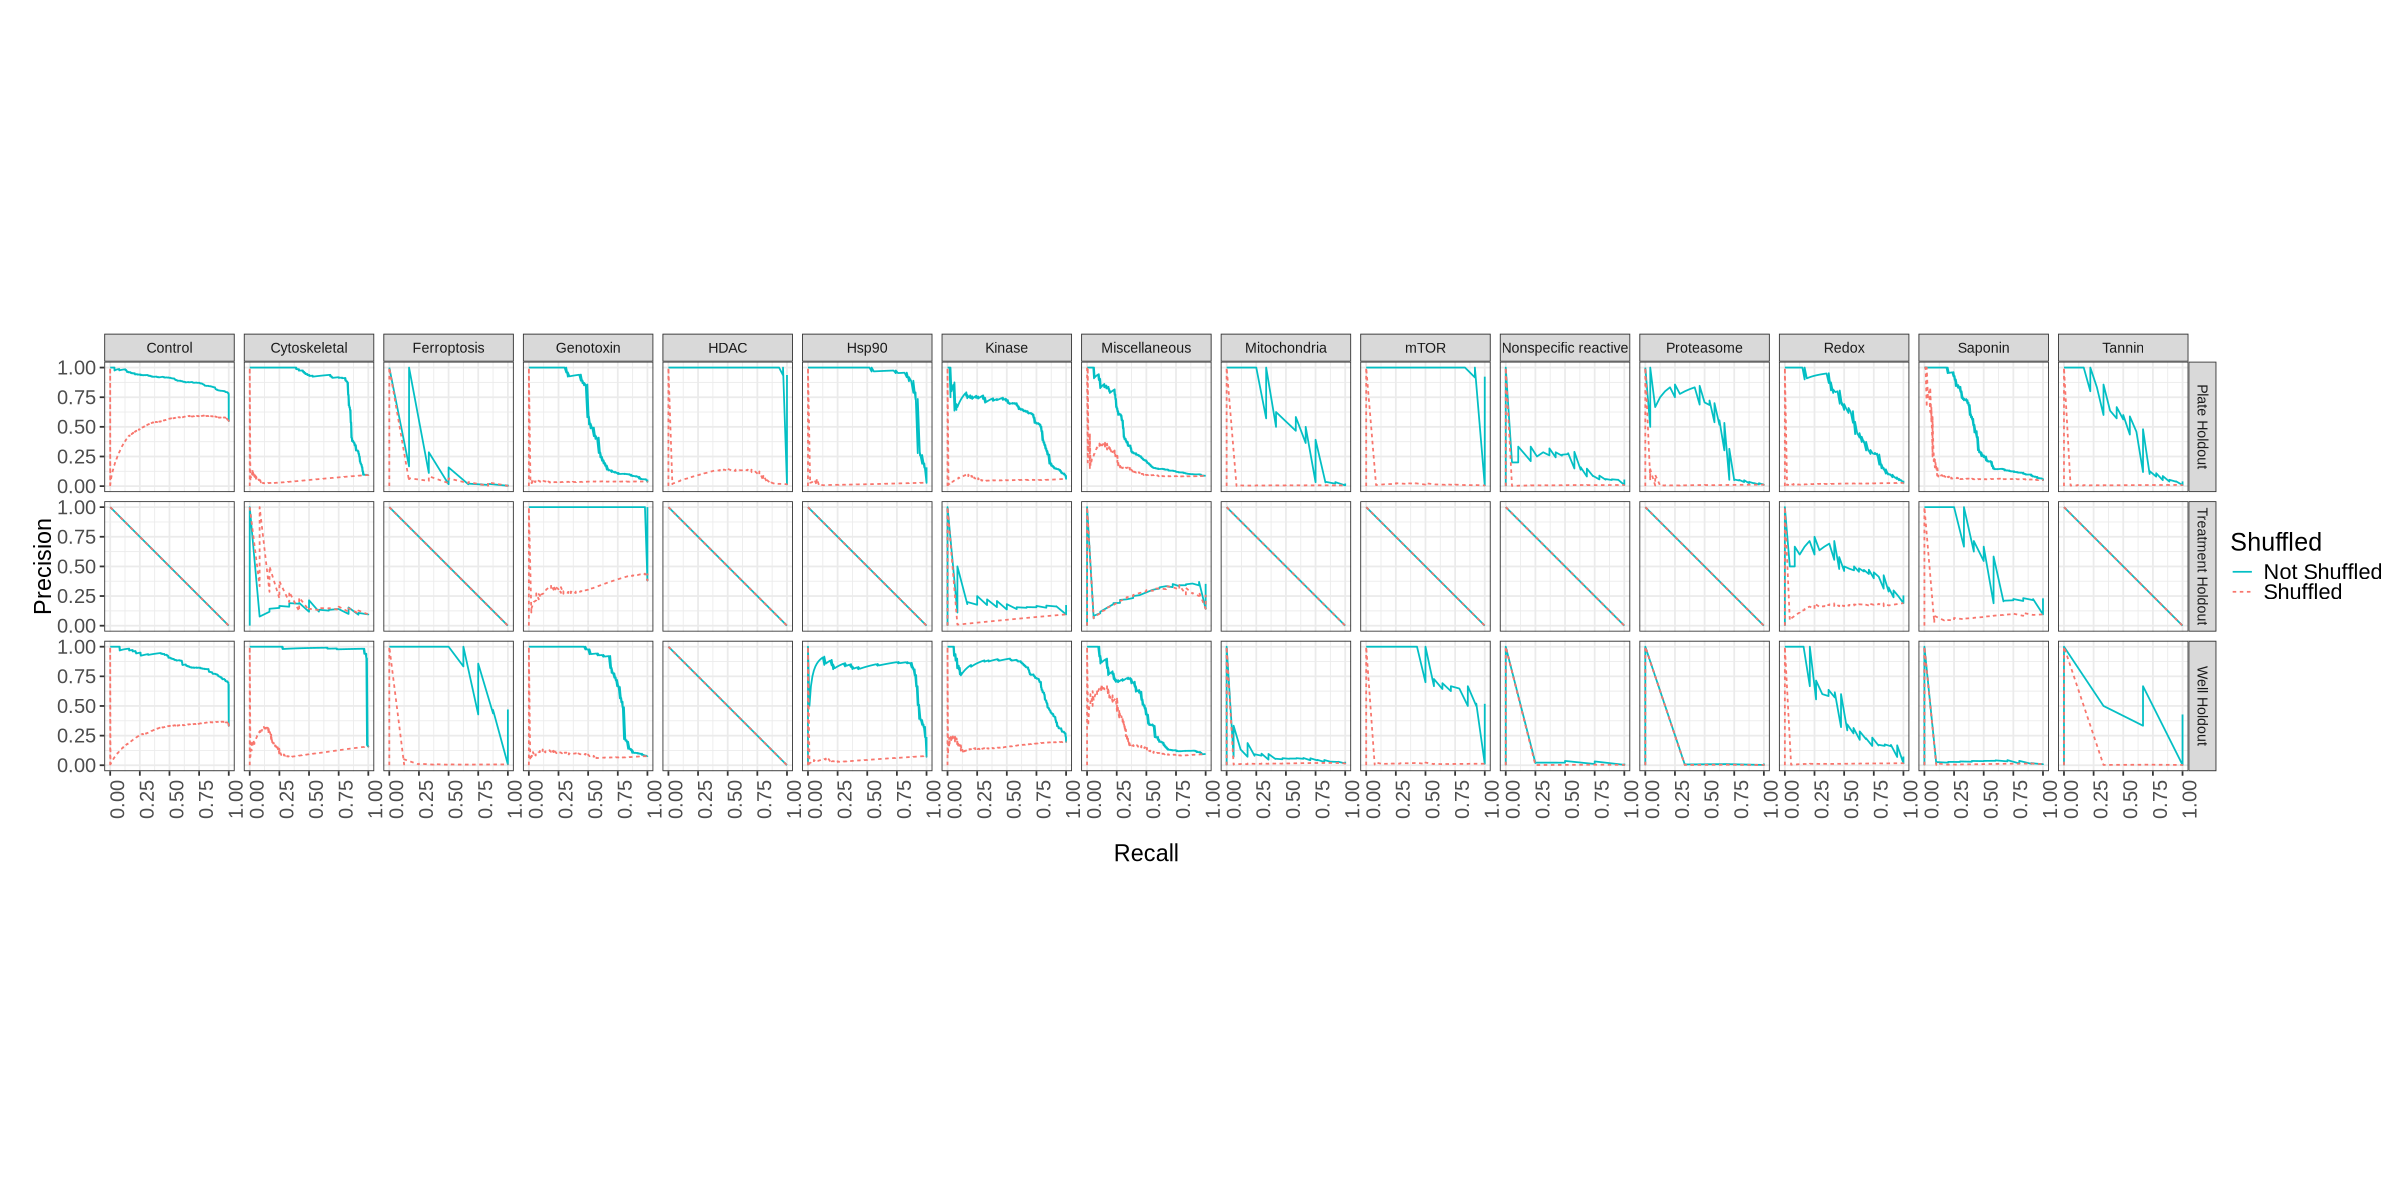

In [ ]:
# creating data frame with only the holdout scores
dataset_order <- c("Plate Holdout", "Treatment Holdout", "Well Holdout")
holdout_pr_df <- pr_df %>%
  filter(dataset_type %in% dataset_order)
holdout_pr_df$dataset_type <- factor(holdout_pr_df$dataset_type, levels = dataset_order)


# Set plot dimensions
width <- 20
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot
holdout_pr_curve_plot <- ggplot(holdout_pr_df, aes(x = recall, y = precision, color = shuffled)) +
  geom_line(aes(linetype = shuffled)) +
  facet_grid(dataset_type ~ injury_type) +
  theme_bw() +

  theme(
    legend.spacing.y = unit(0.1, "cm"),
    legend.box.spacing = unit(0.1, "cm"),
    legend.key.size = unit(0.7, "lines"),
    legend.key.width = unit(1, "lines"),
    legend.title = element_text(size = 15),
    legend.text = element_text(size = 13),

    # facet params
    strip.text = element_text(size = 8.5),
    # strip.text.x = element_text(margin = margin(2,2,2,2, "cm")),

    # axis params
    axis.text.x = element_text(angle = 90, size = 12),
    axis.text.y = element_text(size = 12),
    axis.title = element_text(size = 14),
    axis.title.x.bottom = element_text(margin = margin(t = 15)),
    axis.title.y.left = element_text(margin = margin(l = 15))
    ) +

 scale_color_manual(values = c(
      "Shuffled" = "#f8766d",
      "Not Shuffled" = "#03bfc4"
    )) +

labs(x = "Recall", y = "Precision", linetype = "Shuffled", color = "Shuffled") +
ggplot2::coord_fixed()

# Save the plot
ggsave("figures/supplemental/sfig_holdout_pr_curves.png", width = width, height = height, dpi = 600)
holdout_pr_curve_plot


## Figure 1 Panel E: Probabilities

Picking joint bandwidth of 0.0221



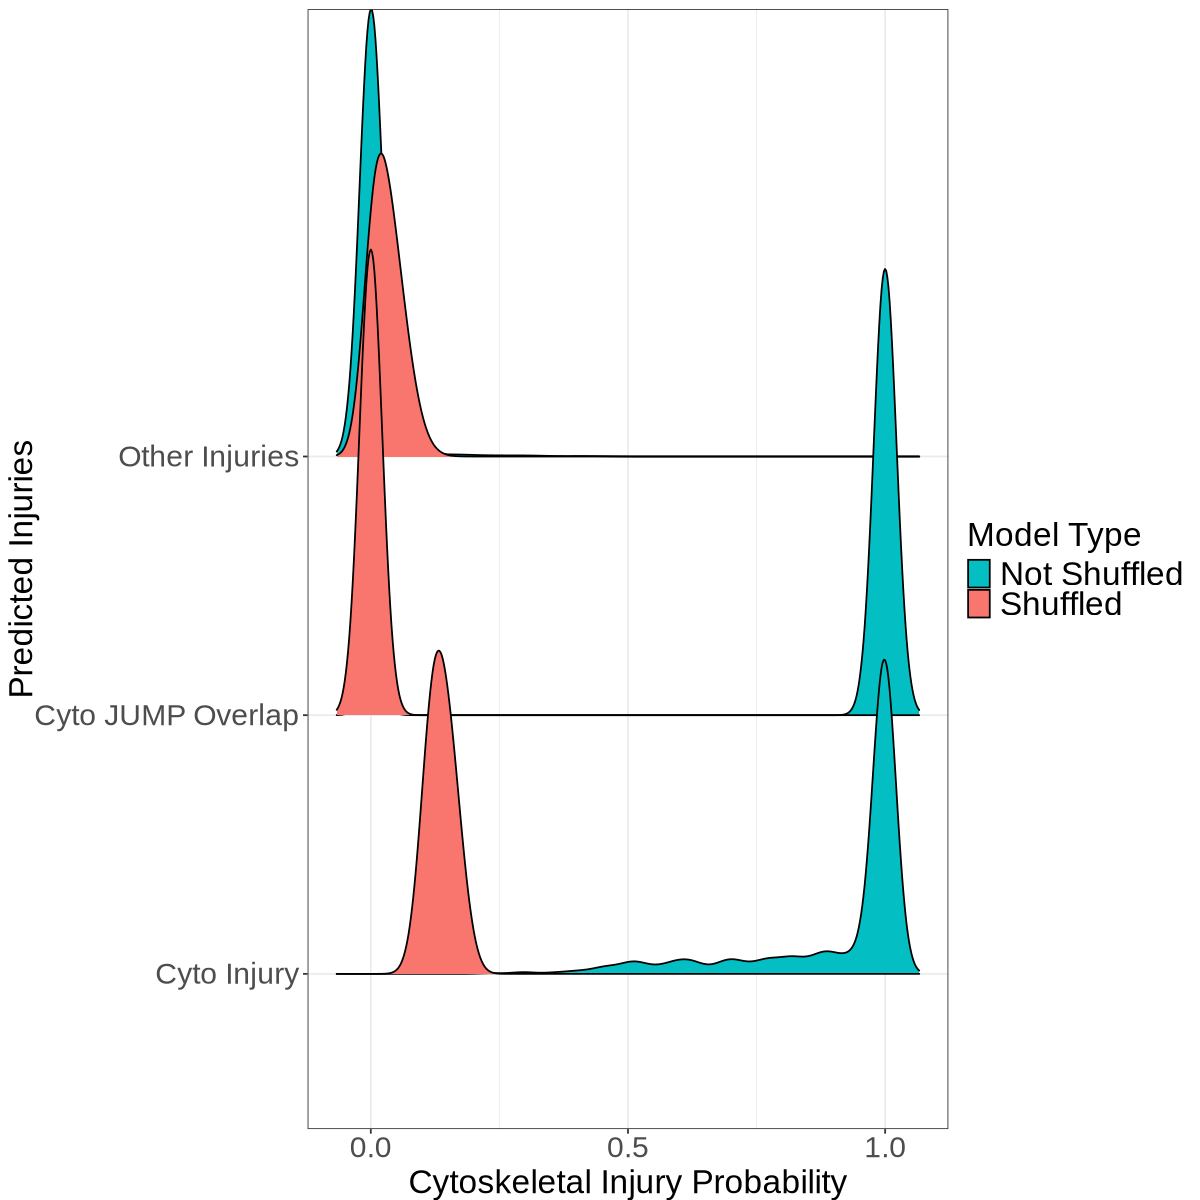

In [ ]:
img_height <- 10
img_width <- 10

options(repr.plot.width = img_width, repr.plot.height = img_height)
fig2_E_probabilities_ridge_plot <- (
    ggplot(cyto_proba_df, aes(x = Cytoskeletal, y = injury, fill = shuffled)) +
    geom_density_ridges() +
    # facet_wrap(~shuffled) +
    scale_x_continuous(breaks = seq(0, 1, 0.5)) +
    theme_bw() +

    # No legend
    theme(plot.title = element_text(size = 20, hjust = 0.5)) +

    # scale_fill_manual(values = c(
    # "Shuffled" = brewer.pal(2, "Dark2")[2],
    # "Not Shuffled" = "#1E93FC"
    # )) +

    theme(
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        axis.title = element_text(size = 20),
        # axis.title.y.left = element_text(margin = margin(t = 20)),
        # axis.title.x.bottom = element_text(margin = margin(t = 20)),

        # legend
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.size = unit(0.7, "lines"),
        legend.key.width = unit(1, "lines"),
        )) +

    # setting colors
    scale_fill_manual(values = c(
    "Shuffled" = "#f8766d",
    "Not Shuffled" = "#03bfc4"
    ))+

    labs(y = "Predicted Injuries", x = "Cytoskeletal Injury Probability", fill = "Model Type")



# fig2_E_probabilities_ridge_plot
fig2_E_probabilities_ridge_plot

## Supplmental Figure Z: Confusion Matrix Applying JUMP data to Multi-Class Logistic Regression Model

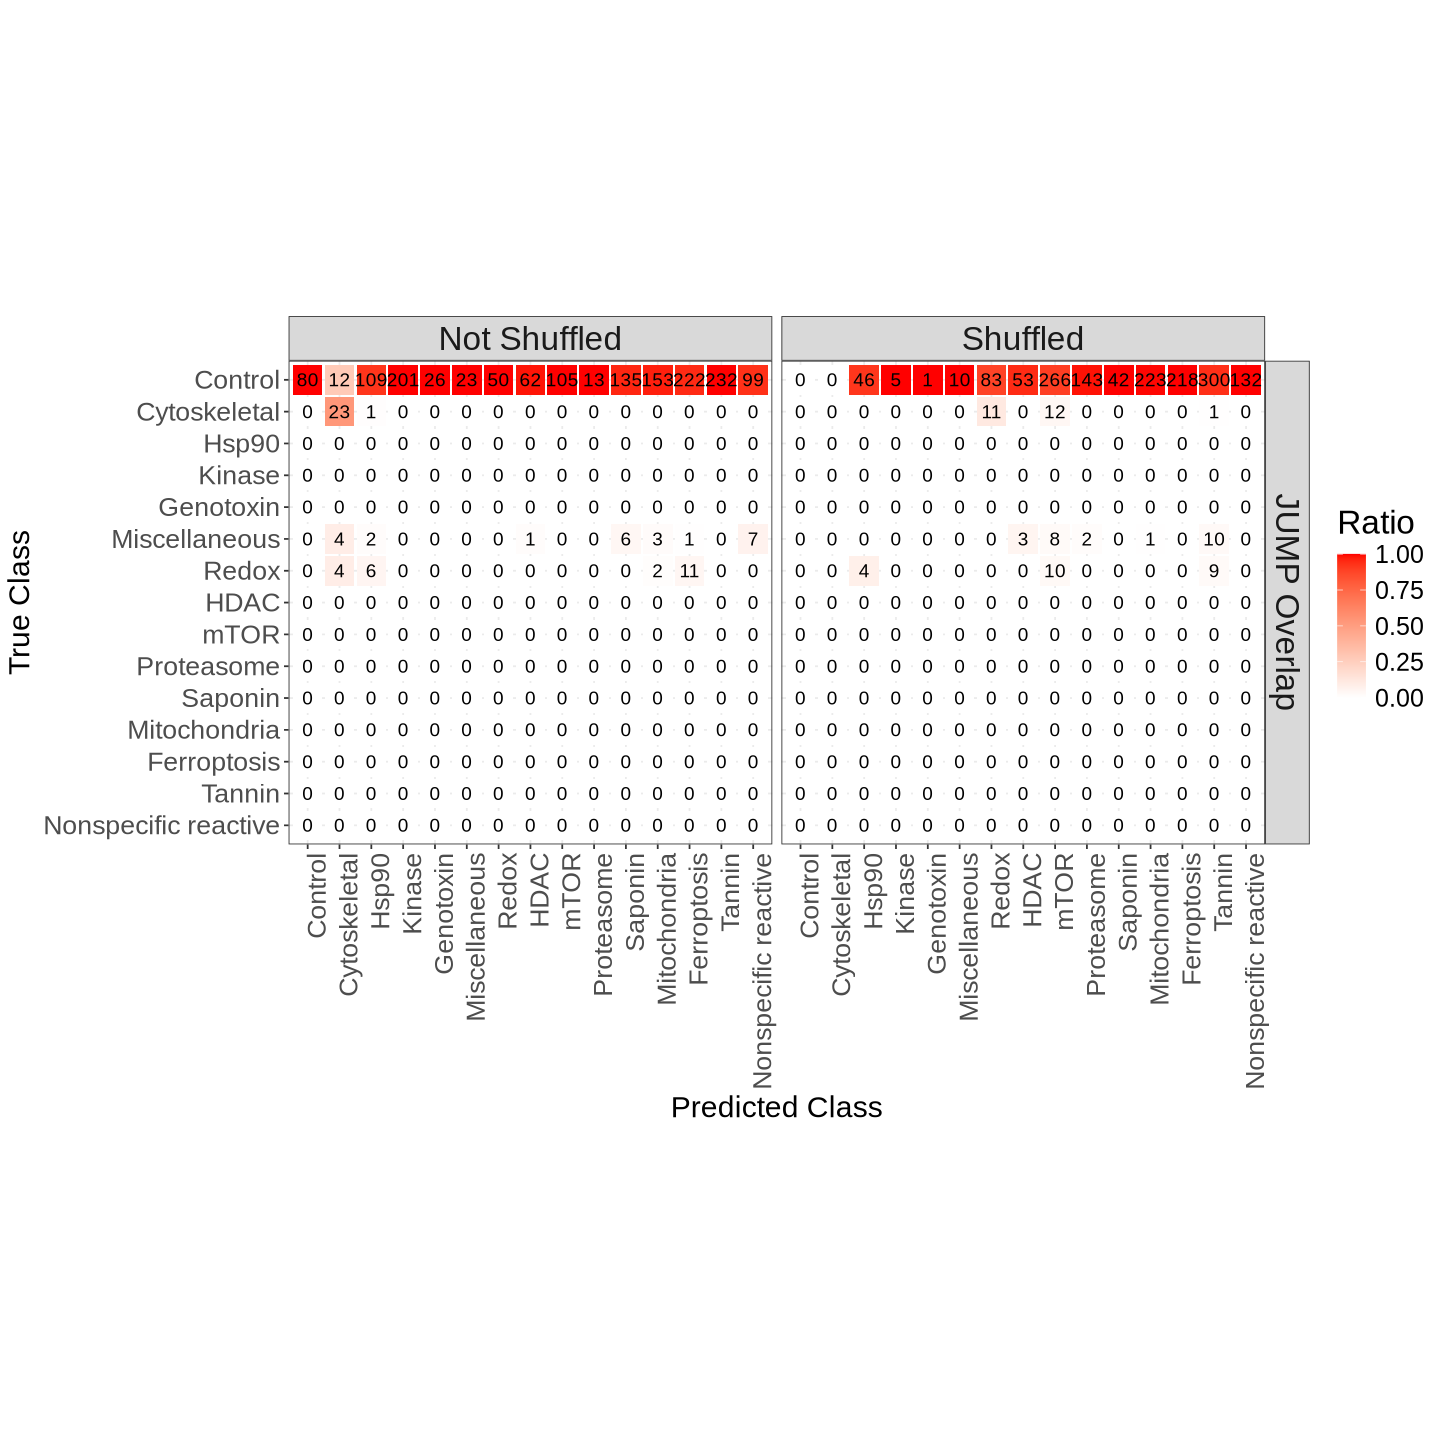

In [24]:
# set image dim
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

# Reorder the predicted_labels factor variable with the desired order
x_label_order <- c('Control', 'Cytoskeletal', 'Hsp90', 'Kinase', 'Genotoxin', 'Miscellaneous', 'Redox', 'HDAC', 'mTOR', 'Proteasome', 'Saponin', 'Mitochondria', 'Ferroptosis', 'Tannin', 'Nonspecific reactive')
overlapping_cm_df$true_labels <- factor(overlapping_cm_df$true_labels, levels = rev(unique(overlapping_cm_df$true_labels)))
overlapping_cm_df$predicted_labels <- factor(overlapping_cm_df$predicted_labels, levels = x_label_order)

# create a confusion matrix plot
overlapping_confusion_matrix_plot <- (
    ggplot(overlapping_cm_df, aes(x = predicted_labels, y = true_labels))
    + facet_grid(dataset_type~shuffled_model)
    + geom_point(aes(color = recall), size = 8, shape = 15)
    + geom_text(aes(label = count), size = 4)
    + scale_color_gradient("Ratio", low = "white", high = "red",limits = c(0, 1))
    + theme_bw()
    + ylab("True Class")
    + xlab("Predicted Class")
    + theme(
        legend.title =  element_text(size = 20, margin = margin(b = 10)),
        legend.text = element_text(size = 15),
        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 16),
        axis.text.y = element_text(hjust = 1, size = 16),
        axis.title.x.bottom = element_text(size = 18),
        axis.title.y.left = element_text(size = 18),
        )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/supplemental/overlapping_confusion_matrix.png", height = height, width = width, dpi=600)

overlapping_confusion_matrix_plot

## Finalizing figure2 with patchwork

Picking joint bandwidth of 0.0221



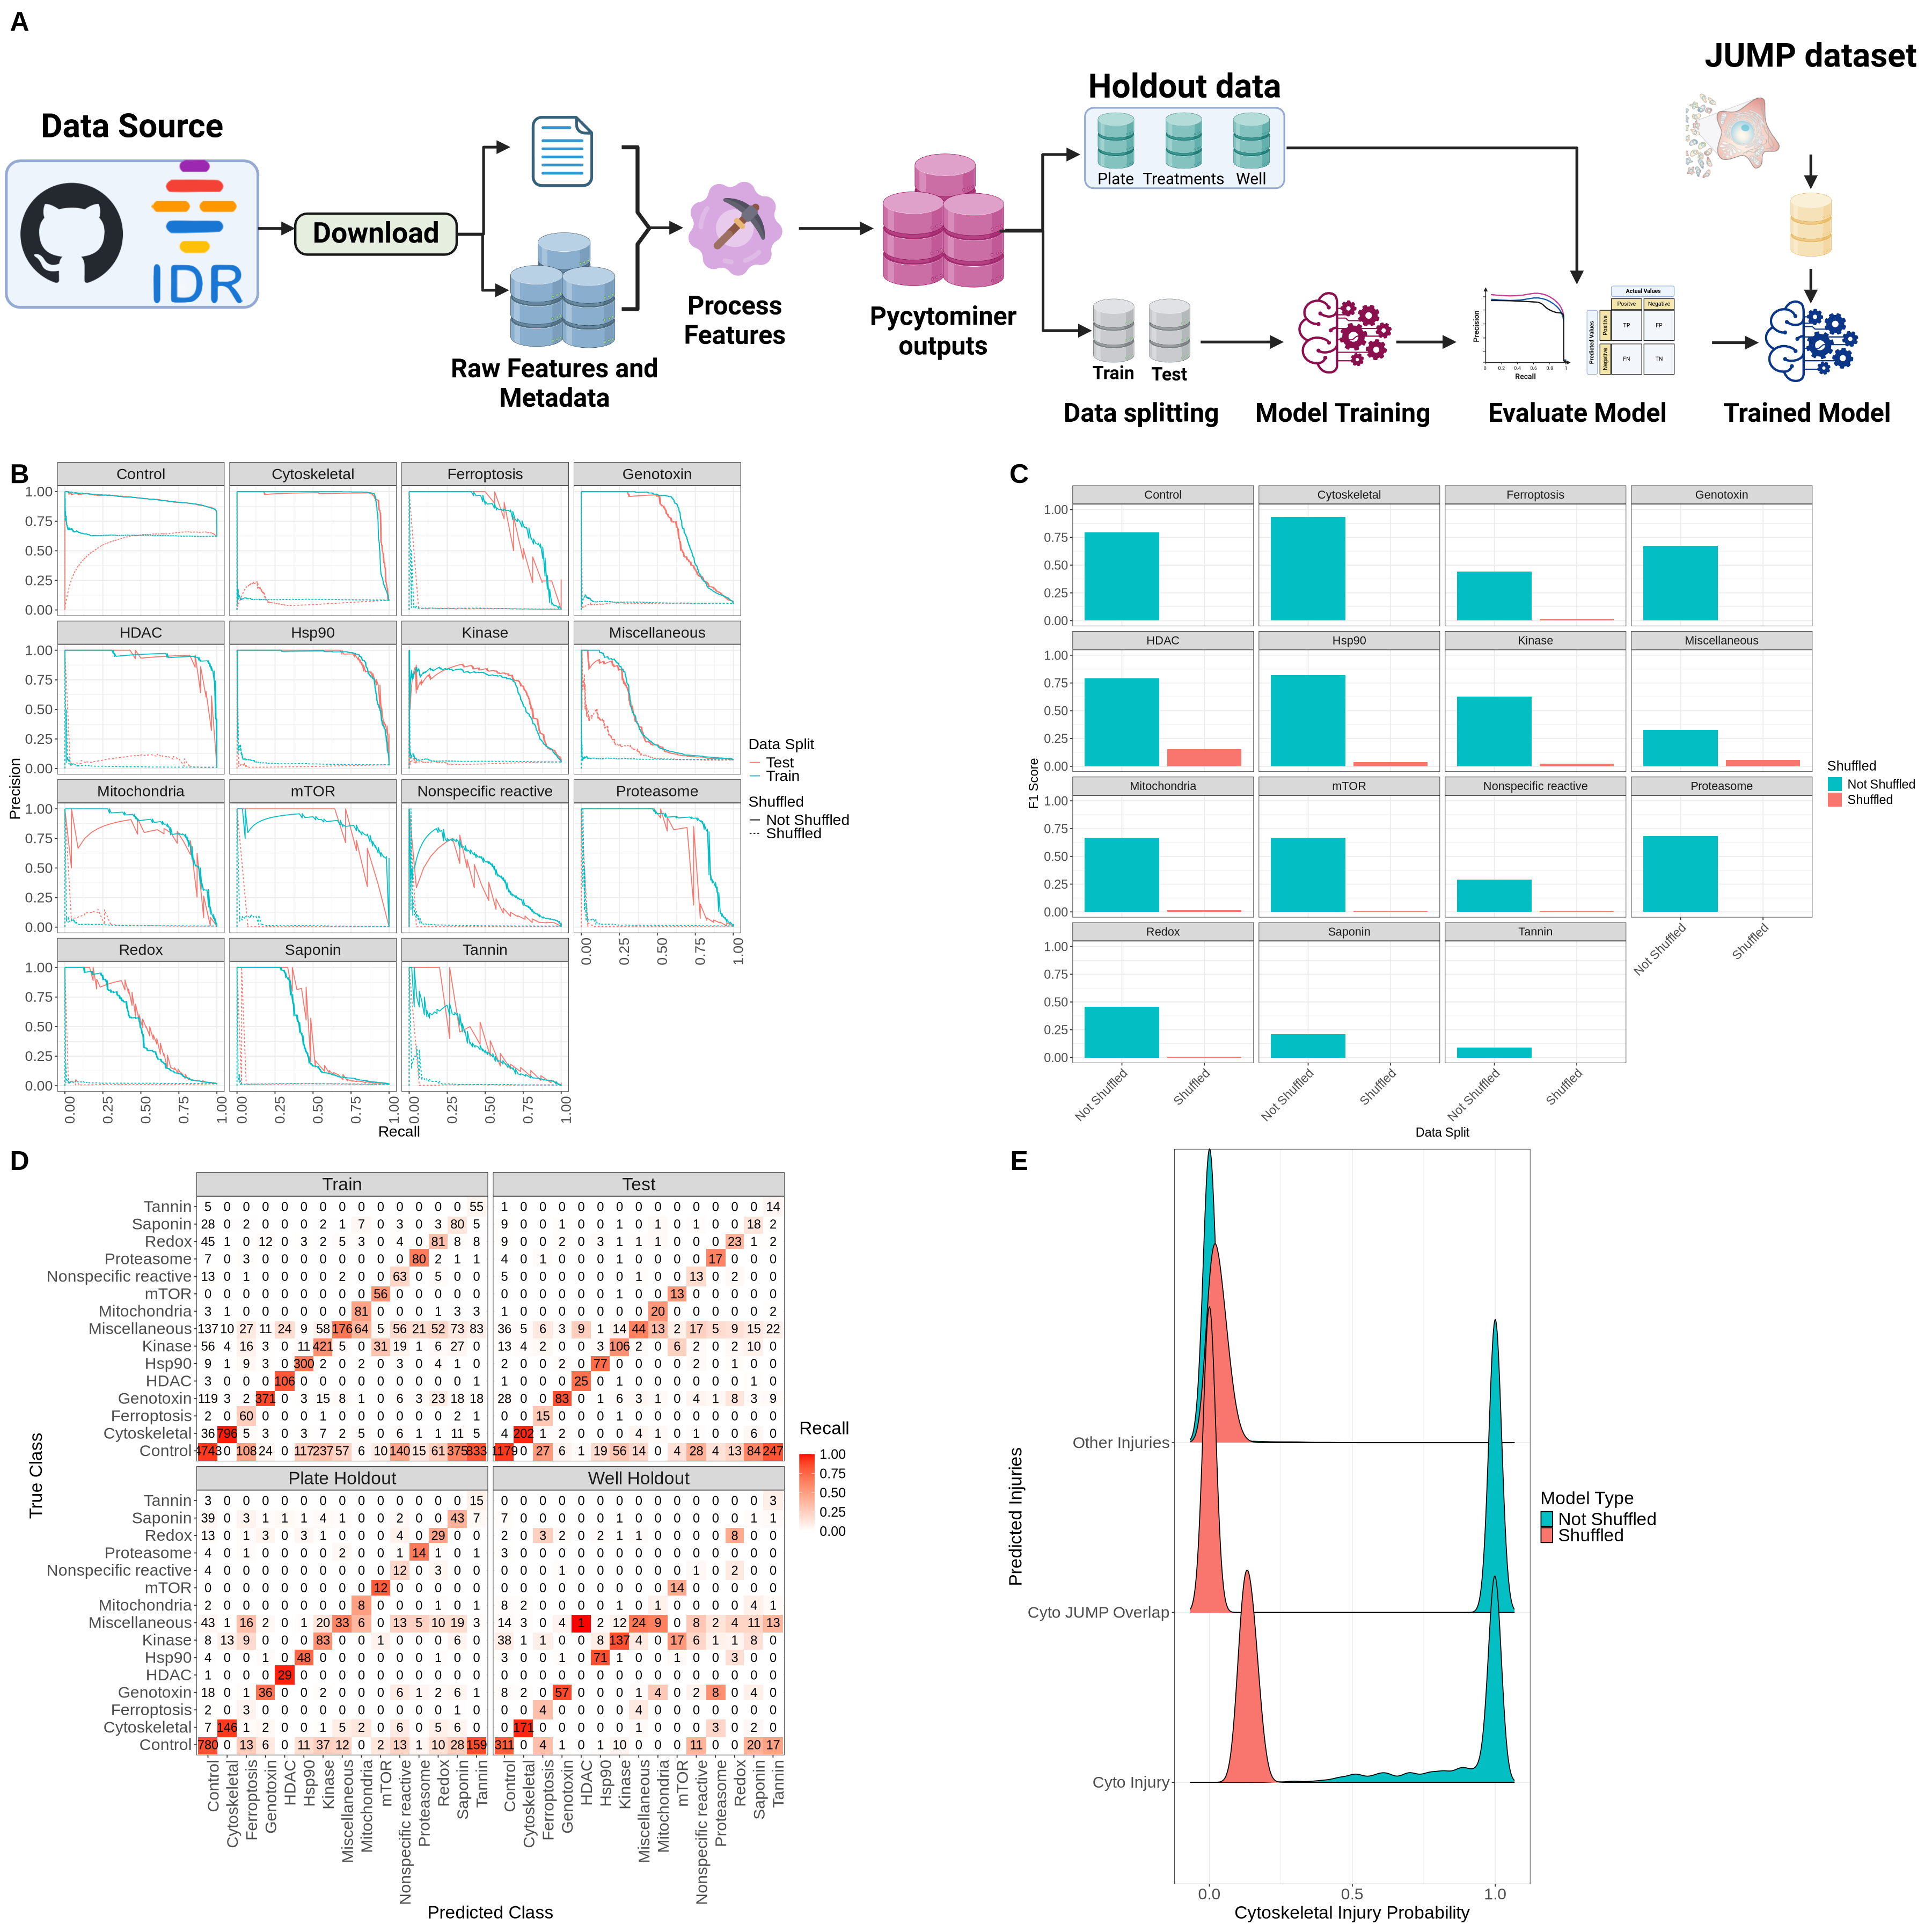

In [ ]:
# Define plot dimensions
height = 30
width = 30


layout <- c(
    area(t=0, b=3, l=0, r=10), # A
    area(t=4, b=7, l=0, r=4), # B
    area(t=4, b=7, l=6, r=10), # C
    area(t=8, b=11, l=0, r=4), # D
    area(t=8, b=11, l=6, r=9) # E
)
options(repr.plot.width=width, repr.plot.height=height, units = "in", dpi = 600)

fig2 <- (
    wrap_elements( full = fig2_A_wf_image)
    + wrap_elements(full = fig2_B_pr_curve_plot_train_test)
    # + wrap_elements(full = fig2_C_f1_bar_plot)
    + fig2_C_f1_bar_plot
    # + wrap_elements(full = fig2_D_final_model_cm)
    + fig2_D_final_model_cm
    + wrap_elements(full = fig2_E_probabilities_ridge_plot)
    # + fig2_E_probabilities_ridge_plot

    # plot layouts
    + plot_layout(design = layout)#, widths = c(10, 10))
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 30, face = "bold"))
)

# Display the combined plot
fig2

# Save the plot
ggsave(
  plot = fig2,
  filename = "Final_Figure2.png",
  height = height,
  width = width,
  dpi = 600
)